# LSTM Implementation

##  Loading and Preprocessing Data
- Load Dataset
- Convert Timestamps
- Select Target Variable
- Normalize Target Variable

In [3]:
import os
import random
import numpy as np
import tensorflow as tf

# Set Global Random Seed for Reproducibility (covers Python, NumPy, TensorFlow, and hashing)
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = 'data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Select Target Variable
target_column = 'DE_load_actual_entsoe_transparency'
target_data = data[[target_column]]  # Keep as DataFrame

# Normalize Target Variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_scaled = scaler.fit_transform(target_data)

print(f"Dataset Shape: {target_data.shape}")


Dataset Shape: (43824, 1)


## Data Splitting and Sequence Preparation
- Split Data into Train (70%), Validation (15%), and Test (15%)
- Create Sequences for Time-Series Forecasting
- Reshape Data for LSTM Input

In [4]:
# Split Data into Train (70%), Temp (30%) → Then Split Temp into Validation (15%) & Test (15%)
train_ratio = 0.7
train_data, temp_data = train_test_split(target_data_scaled, train_size=train_ratio, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}, Test Size: {len(test_data)}")

# Function to Create Sequences for Time-Series Forecasting
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Past `time_steps` values
        y.append(data[i + time_steps])  # Target value at next step
    return np.array(X), np.array(y)

# Define Sequence Length (e.g., last 24 hours → predict next hour)
time_steps = 24  

# Create Sequences for Train, Validation, and Test Sets
X_train, y_train = create_sequences(train_data, time_steps)
X_val, y_val = create_sequences(val_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape Data for LSTM Input (Samples, Time Steps, Features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Train Sequences: {X_train.shape}, Train Labels: {y_train.shape}")
print(f"Validation Sequences: {X_val.shape}, Validation Labels: {y_val.shape}")
print(f"Test Sequences: {X_test.shape}, Test Labels: {y_test.shape}")


Train Size: 30676, Validation Size: 6574, Test Size: 6574
Train Sequences: (30652, 24, 1), Train Labels: (30652, 1)
Validation Sequences: (6550, 24, 1), Validation Labels: (6550, 1)
Test Sequences: (6550, 24, 1), Test Labels: (6550, 1)


## Simple Baseline Model

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0700 - val_loss: 0.0047
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0012 - val_loss: 0.0011
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step

Final Test MAPE: 0.0631


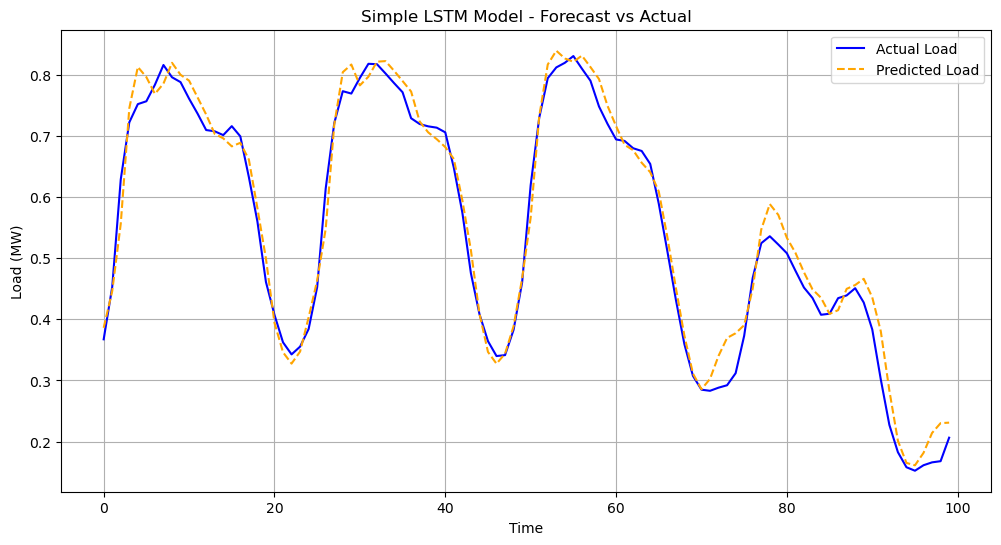

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

# Define the LSTM model
def build_simple_lstm(input_shape):
    model = Sequential([
        LSTM(units=10, input_shape=input_shape),  # 10 units in LSTM layer
        Dense(1)  # Single output neuron
    ])
    
    model.compile(optimizer='adam', loss='mse')  # MSE loss, Adam optimizer
    return model

# Build Model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time steps, features)
simple_lstm = build_simple_lstm(input_shape)

# Train the Model 
simple_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Generate Predictions
test_predictions = simple_lstm.predict(X_test)

# Evaluate Test Performance
test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

# Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Simple LSTM Model - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## 50 Units

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0275 - val_loss: 0.0019
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0011 - val_loss: 8.8942e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.8265e-04 - val_loss: 8.1143e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.1122e-04 - val_loss: 7.7136e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0528


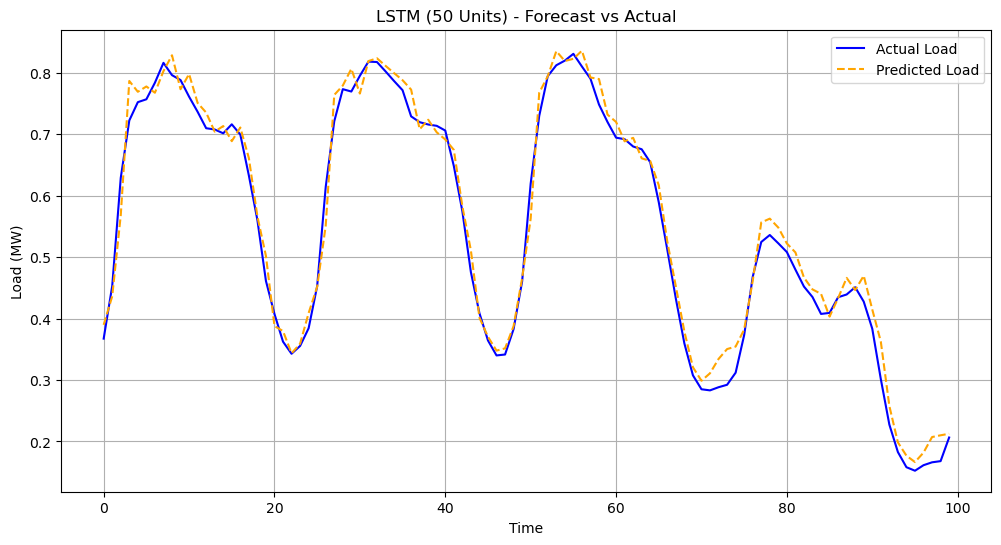

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

# Define the LSTM model with 50 units
def build_lstm_with_50_units(input_shape):
    model = Sequential([
        LSTM(units=50, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build Model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_50 = build_lstm_with_50_units(input_shape)

# Train the Model
lstm_50.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Generate Predictions
test_predictions = lstm_50.predict(X_test)

# Evaluate MAPE
test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

# Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Dropouts 20%

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0390 - val_loss: 0.0042
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 9.6692e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0619


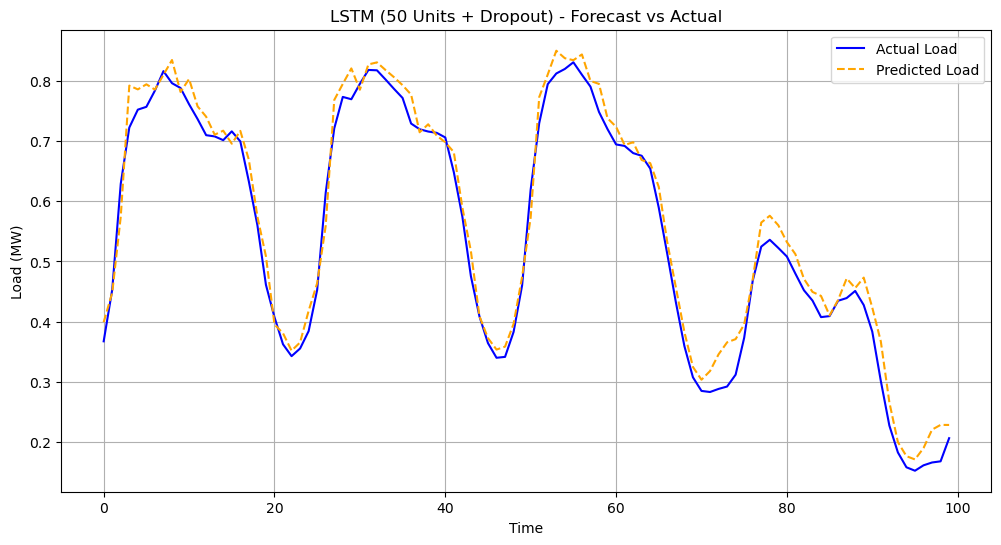

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_lstm_with_dropout(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_dropout = build_lstm_with_dropout(input_shape)

lstm_dropout.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

test_predictions = lstm_dropout.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units + Dropout) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Dropout 10%

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0305 - val_loss: 0.0028
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0016 - val_loss: 7.8026e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0014 - val_loss: 7.6759e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Final Test MAPE: 0.0484


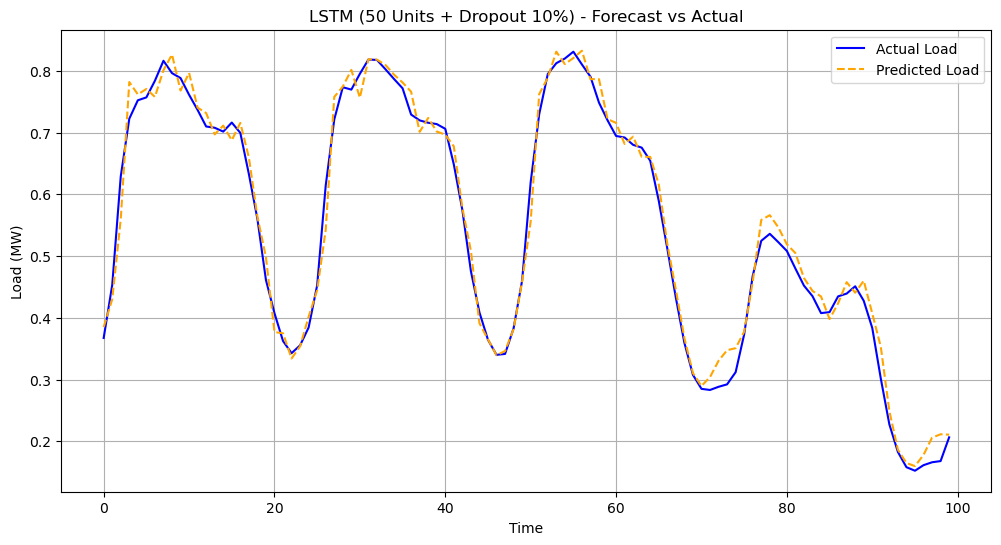

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_lstm_with_dropout(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=False, input_shape=input_shape),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_dropout_10 = build_lstm_with_dropout(input_shape)

lstm_dropout_10.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

test_predictions = lstm_dropout_10.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("LSTM (50 Units + Dropout 10%) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## 2 Layers 50 and 30 units

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0309 - val_loss: 0.0019
Epoch 2/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 3/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0020 - val_loss: 8.0836e-04
Epoch 4/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0017 - val_loss: 7.4956e-04
Epoch 5/5
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0014 - val_loss: 7.5555e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Final Test MAPE: 0.0445


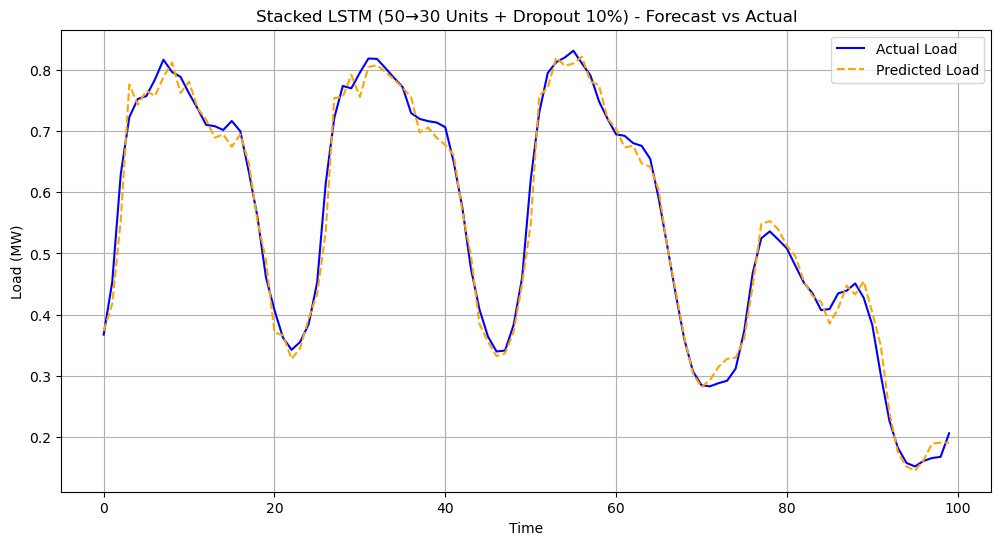

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        LSTM(units=30, return_sequences=False),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
stacked_lstm = build_stacked_lstm(input_shape)

stacked_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)

test_predictions = stacked_lstm.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Stacked LSTM (50→30 Units + Dropout 10%) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


## 20 Epochs

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0320 - val_loss: 0.0037
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0029 - val_loss: 8.1232e-04
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0020 - val_loss: 8.3360e-04
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0016 - val_loss: 7.5347e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0014 - val_loss: 7.2417e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - val_loss: 6.6783e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0010 - val_loss: 6.9280e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 9.4217e-04 - val_loss: 5.9248e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.2169e-04 - val_loss: 5.4604e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7.3727e-04 - val_loss: 4.5764e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.8569e-04 - val_loss: 4.4131e-04
Epoch 

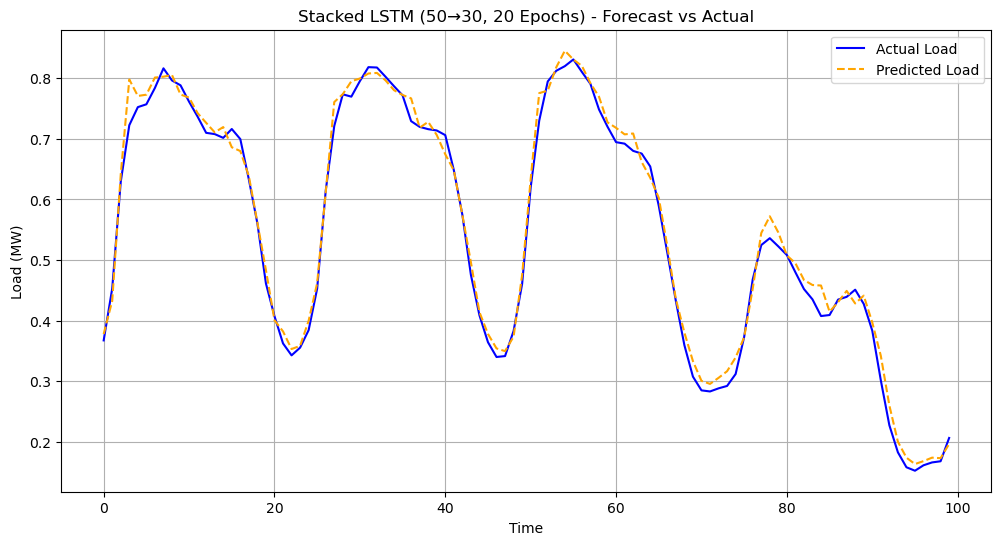

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        LSTM(units=30),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
stacked_lstm_long = build_stacked_lstm(input_shape)

stacked_lstm_long.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

test_predictions = stacked_lstm_long.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Stacked LSTM (50→30, 20 Epochs) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Early Stopping patience=3

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0286 - val_loss: 0.0019
Epoch 2/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0032 - val_loss: 9.6327e-04
Epoch 3/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0021 - val_loss: 7.7790e-04
Epoch 4/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0016 - val_loss: 9.9080e-04
Epoch 5/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0014 - val_loss: 9.0038e-04
Epoch 6/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - val_loss: 7.8379e-04
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Final Test MAPE: 0.0471


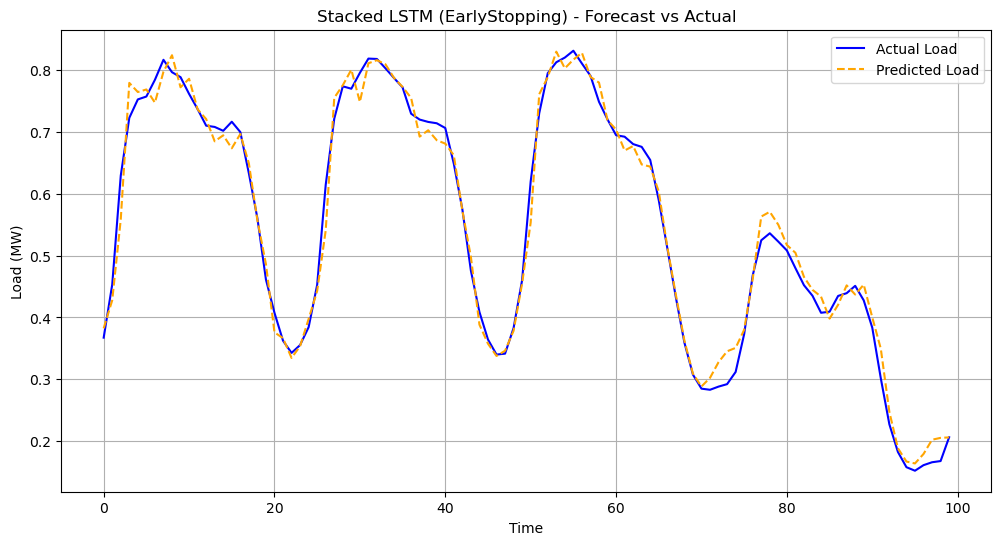

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        LSTM(units=30),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
stacked_lstm_early = build_stacked_lstm(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

stacked_lstm_early.fit(
    X_train, y_train,
    epochs=50,               
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

test_predictions = stacked_lstm_early.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Stacked LSTM (EarlyStopping) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Early Stopping Patience=5

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0273 - val_loss: 0.0029
Epoch 2/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 3/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0019 - val_loss: 9.0350e-04
Epoch 4/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0016 - val_loss: 7.8717e-04
Epoch 5/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0013 - val_loss: 6.9222e-04
Epoch 6/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - val_loss: 6.6975e-04
Epoch 7/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0010 - val_loss: 6.2926e-04
Epoch 8/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 8.9437e-04 - val_loss: 5.9720e-04
Epoch 9/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 7.8744e-04 - val_loss: 7.2785e-04
Epoch 10/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 7.0835e-04 - val_loss: 4.7142e-04
Epoch 11/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.5240e-04 - val_loss: 5.0226e-04
Epoch 12/5

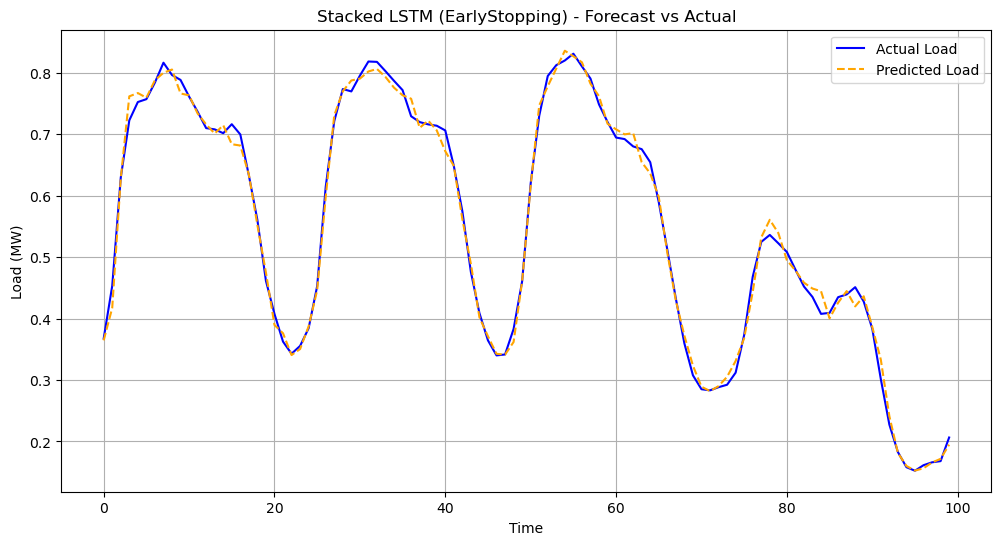

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        LSTM(units=30),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
stacked_lstm_early = build_stacked_lstm(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

stacked_lstm_early.fit(
    X_train, y_train,
    epochs=50,               
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

test_predictions = stacked_lstm_early.predict(X_test)

test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Stacked LSTM (EarlyStopping) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## KerasTuner

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False
    ))
    
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=Adam(), loss='mse')
    return model

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,                 
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='electricity_forecast'
)


Reloading Tuner from lstm_tuning/electricity_forecast/tuner0.json


In [17]:
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

Trial 15 Complete [00h 00m 45s]
val_loss: 0.0006217042100615799

Best val_loss So Far: 0.0004464137018658221
Total elapsed time: 00h 16m 25s


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout')}")

Best number of units: 128
Best dropout rate: 0.1


## Final Model

Epoch 1/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0239 - val_loss: 0.0022
Epoch 2/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 3/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0014 - val_loss: 7.4099e-04
Epoch 4/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0011 - val_loss: 7.0422e-04
Epoch 5/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0011 - val_loss: 7.2488e-04
Epoch 6/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 9.9083e-04 - val_loss: 6.4257e-04
Epoch 7/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 9.3714e-04 - val_loss: 6.3969e-04
Epoch 8/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 8.5145e-04 - val_loss: 6.2822e-04
Epoch 9/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.7625e-04 - val_loss: 5.1791e-04
Epoch 10/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 6.8178e-04 - val_loss: 4.0683e-04
Epoch 11/20
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 6.04

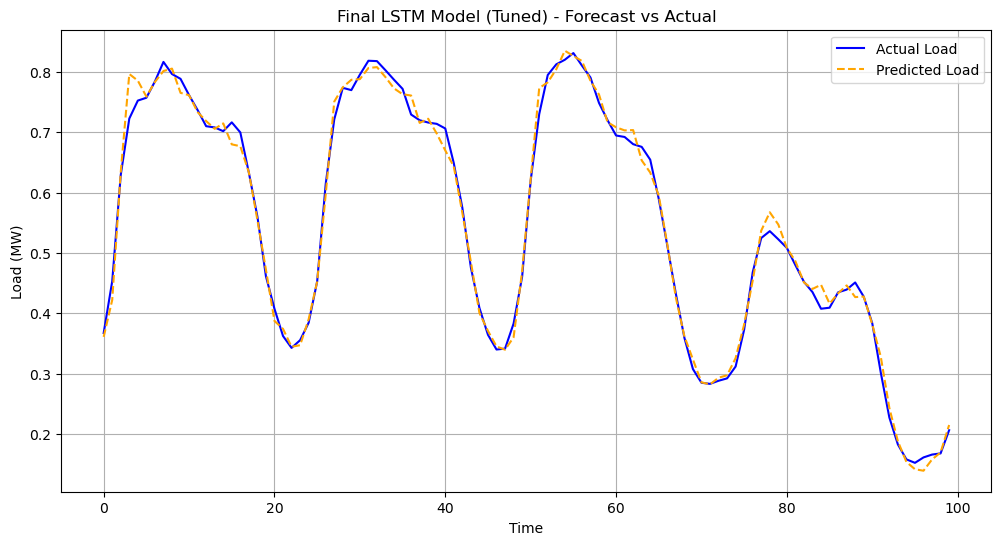

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

final_model = Sequential()
final_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(0.1))
final_model.add(Dense(1))

final_model.compile(optimizer=Adam(), loss='mse')

history = final_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

test_predictions = final_model.predict(X_test)

from sklearn.metrics import mean_absolute_percentage_error as mape
test_mape = mape(y_test, test_predictions)
print(f"Final Test MAPE: {test_mape:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Final LSTM Model (Tuned) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0256 - val_loss: 0.0026
Epoch 2/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0015 - val_loss: 7.5122e-04
Epoch 4/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0011 - val_loss: 7.0709e-04
Epoch 5/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0011 - val_loss: 6.6131e-04
Epoch 6/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0010 - val_loss: 6.3282e-04
Epoch 7/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 9.4376e-04 - val_loss: 5.9215e-04
Epoch 8/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 8.6204e-04 - val_loss: 6.3356e-04
Epoch 9/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.9788e-04 - val_loss: 5.0997e-04
Epoch 10/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.2735e-04 - val_loss: 4.8486e-04
Epoch 11/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 6.2838e-04 - val_lo

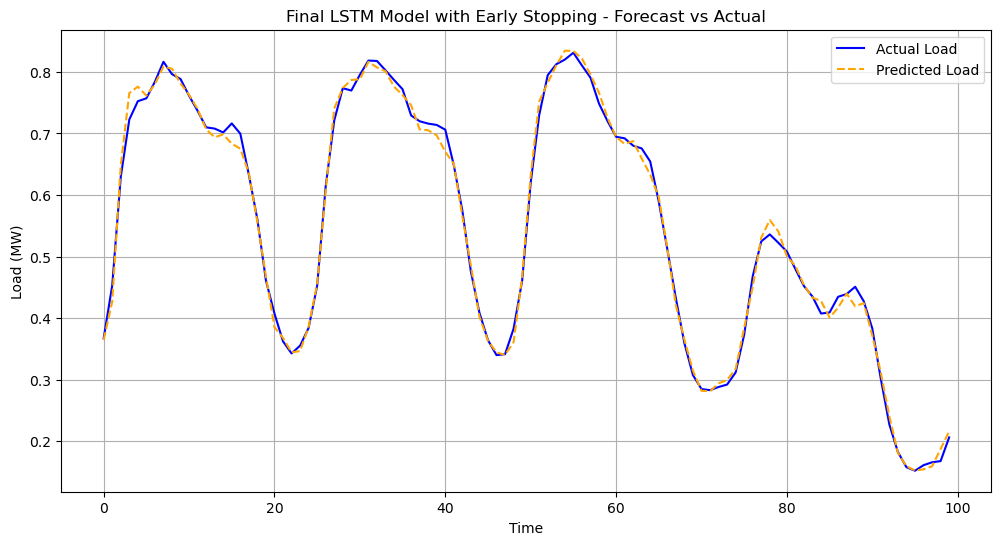

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

final_model = Sequential()
final_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(0.1))
final_model.add(Dense(1))

final_model.compile(optimizer=Adam(), loss='mse')

history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

test_predictions = final_model.predict(X_test)
test_mape = mape(y_test, test_predictions)
print(f"Final Test MAPE (Early Stopping): {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Final LSTM Model with Early Stopping - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Stacked LSTM

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


958/958 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0267 - val_loss: 0.0015
Epoch 2/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0027 - val_loss: 8.4444e-04
Epoch 3/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0019 - val_loss: 8.0489e-04
Epoch 4/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0016 - val_loss: 7.2388e-04
Epoch 5/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0014 - val_loss: 7.7289e-04
Epoch 6/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0012 - val_loss: 6.7472e-04
Epoch 7/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0010 - val_loss: 6.7746e-04
Epoch 8/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 9.4047e-04 - val_loss: 5.2677e-04
Epoch 9/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 7.8609e-04 - val_loss: 5.1466e-04
Epoch 10/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 7.2252e-04 - val_loss: 4.3396e-04
Epoch 11/50
958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 6.6711e-04 - val_loss: 4.1445e-04
E

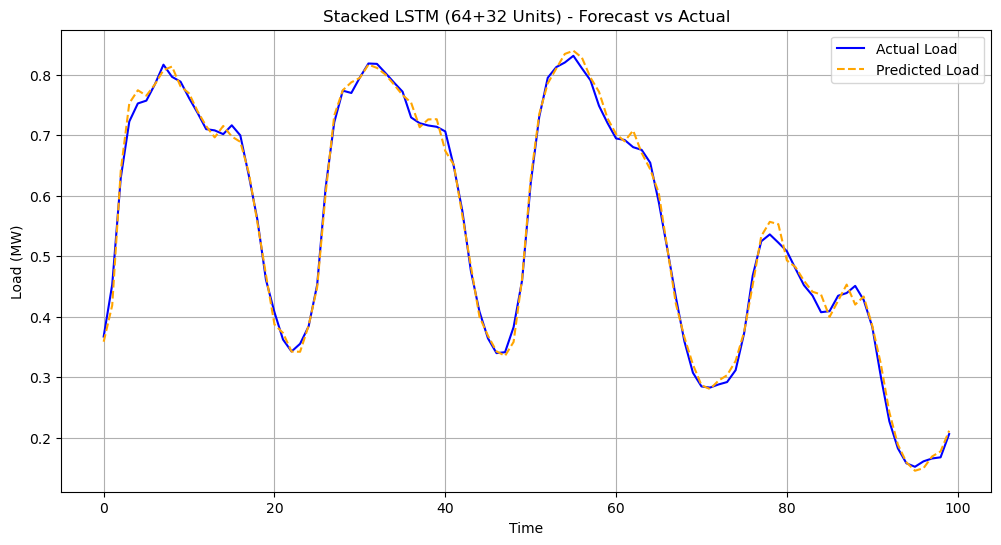

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

test_predictions = model.predict(X_test)
test_mape = mape(y_test, test_predictions)
print(f"Final Test MAPE (Stacked LSTM): {test_mape:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Stacked LSTM (64+32 Units) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()